* Image denoising is to remove noise from a noisy image, so as to restore the true image
* CIFAR10 dataset
* Image is grayscale of size 48*48

# Importing libraries

In [1]:
from keras.datasets import fashion_mnist, mnist
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model

import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd# Any results you write to the current directory are saved as output.
from IPython.display import display, Image

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
#from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
import tensorflow as tf

# Any results you write to the current directory are saved as output.
from IPython.display import display, Image

In [2]:
(X_train,Y_train),(X_test, Y_test) = tf.keras.datasets.cifar10.load_data()


170498071/170498071 [==============================] - 3s 0us/step


In [3]:
X_train.shape

(50000, 32, 32, 3)

# Data Preprocessing

# noise factor: 0.07

In [4]:
#NOrmalizing the images
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.

#reshaping the images
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format


#adding noise in data
noise_factor = 0.07

from skimage.util import random_noise

#noisy = random_noise(img, mode="poisson")
#just change the mode pf the noise to-->'gaussain',
x_train_noisy = random_noise(x_train, mode="s&p",clip=True, amount=noise_factor)
x_test_noisy = random_noise(x_test, mode="s&p",clip=True, amount=noise_factor)

# Taking 100 images seperate for final testing

In [5]:
x_test_final_noisy = x_test_noisy[-100:]
x_test_noisy = x_test_noisy[:-100]

x_test_final_original = x_test[-100:]
x_test = x_test[:-100]

# Visualization of 10 Data

In [6]:
n = 5

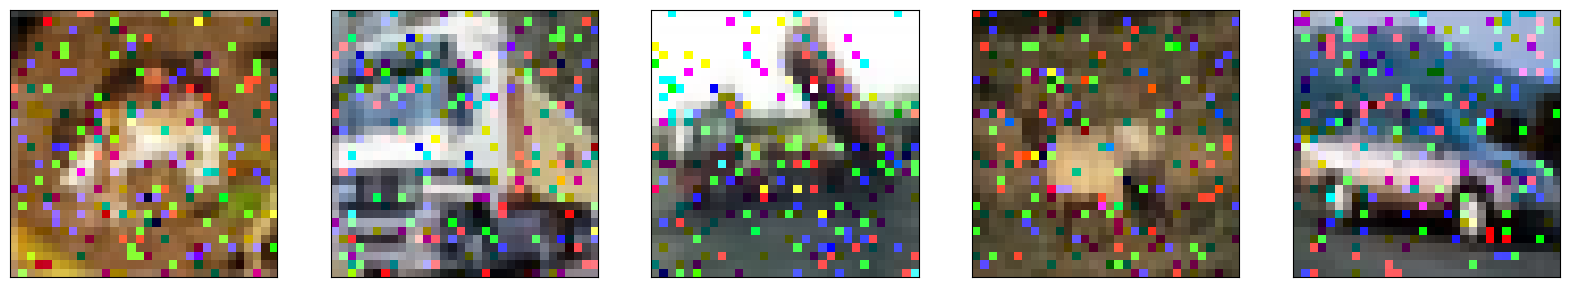

In [7]:
plt.figure(figsize=(20, 20))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train_noisy[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# One of the way we can achieve our goal of removing noise is AutoEncoder

**Copied from Keras Blog(https://blog.keras.io/building-autoencoders-in-keras.html):
**
* What are autoencoders good for?
* Today two interesting practical applications of autoencoders are data denoising (which we feature later in this post), and dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

**Refer to Keras Blog for better idea : https://blog.keras.io/building-autoencoders-in-keras.html**

## AutoEncoder Architecture

# Construction of Model

In [8]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(input_layer)
    conv1 = Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    #Middle
    convm = Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(pool4)
    convm = Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(convm)

    #upconv part
    deconv4 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons*3, (3,3), activation='relu', padding='same')(uconv1)
    uconv1 = Conv2D(start_neurons*3, (3,3), activation='relu', padding='same')(uconv1)

    output_layer = Conv2D(3, (1,1), padding='same', activation='sigmoid')(uconv1)
    print(output_layer.shape)
    return output_layer

In [9]:
#Defining target image size and Input size and building model
img_size_target = 32
input_layer = Input((img_size_target, img_size_target,3))
output_layer = build_model(input_layer,64)

(None, 32, 32, 3)


In [10]:
#Initializing and compiling model
model_unet = Model(input_layer, output_layer)
model_unet.compile(optimizer='adam', loss='MSE')

# AutoEncoder Summary

In [11]:
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

# Training Model

In [12]:
model_unet.fit(x_train_noisy, x_train,
                epochs=3,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/3
782/782 [==============================] - 220s 245ms/step - loss: 0.0073 - val_loss: 0.0031
Epoch 2/3
782/782 [==============================] - 180s 231ms/step - loss: 0.0018 - val_loss: 9.6898e-04
Epoch 3/3
782/782 [==============================] - 181s 231ms/step - loss: 0.0012 - val_loss: 6.7341e-04


## Making Prediction

In [13]:
predict = model_unet.predict(x_test_final_noisy)

4/4 [==============================] - 6s 655ms/step


# Visualizing the prediction

## Original Test images

In [14]:
n=10

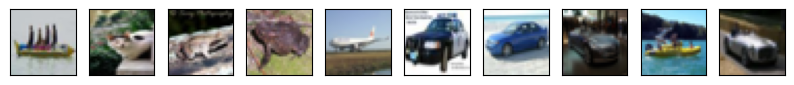

In [15]:
plt.figure(figsize=(10, 10))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_final_original[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Noised Test images

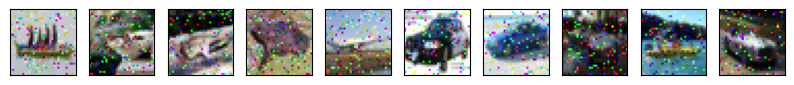

In [16]:
plt.figure(figsize=(10, 10))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_final_noisy[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Generated Test images

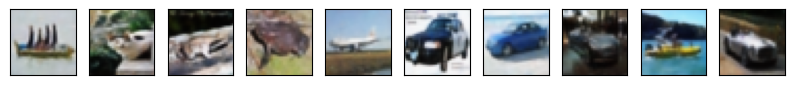

In [17]:
plt.figure(figsize=(10, 10))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()